In [19]:
import os
import glob
import collections
import subprocess as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from operator import itemgetter
from networkx.drawing.nx_agraph import read_dot, graphviz_layout

import stats
import graphs
import sqlite_helper as helper

In [20]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)
print("Updates imports")

Updates imports


TODOS:
[] Failed benchmarks also need to be removed from full graph
[] remove split thing everywhere

#### Helpers

In [3]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

def get_name_from_db_bench(name):
    return name.replace("/", "-")

In [82]:
def change(rl: float, ru: float):
    if ru < 1:
        return (1-ru) * 100
    elif rl > 1:
        return (rl-1) * 100
    else:
        return 0

In [83]:
# Hierachical Bootstrap
def boostrap_ratio_mean_laaber(benchmark: dict, num_iterations: int=10000):
    bootstrap_mean = []
    for _ in range(num_iterations):
        samples = []
        trials = list(benchmark.keys())
        for _ in trials:
            # Pick random trial
            random_trial = np.random.choice(trials, replace=True)
            iterations = list(benchmark[random_trial])
            
            for _ in iterations:
                # Pick random iteration
                random_iteration_idx = np.random.choice(len(iterations), replace=True)
                ns = iterations[random_iteration_idx][2]
                samples.append(ns)

        bootstrap_mean.append(np.mean(samples))  
    return bootstrap_mean          


# Loading Data for instability

In [ ]:
db_path_tags = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/measurements.db"

In [4]:
measurements = helper.get_all_measurements(db_path_tags, start_form_count=1)

# group by tag/version
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

# group by benchmark name
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

In [84]:
# group by trial
for tag in grouped_by_tag.keys():
    for bench in grouped_by_tag[tag].keys():
        grouped_by_tag[tag][bench] = helper.group_measurements_by_property(grouped_by_tag[tag][bench], -5)

v1.2.0 BenchmarkChecksum/checksum-1 1.2504794753787867
v1.2.0 BenchmarkChecksum/checksum-1024 0.7369759755678515
v1.2.0 BenchmarkChecksum/checksum-compressed-32768 0.6567045269857351
v1.2.0 BenchmarkChecksum/checksum-16 3.0419847815309775
v1.2.0 BenchmarkChecksum/checksum-compressed-16 0.5991391858828435
v1.2.0 BenchmarkChecksum/checksum-2 0.9018525639033326
v1.2.0 BenchmarkChecksum/checksum-compressed-2 0.9062715231296665
v1.2.0 BenchmarkChecksum/checksum-compressed-262144 1.6878630088980457
v1.2.0 BenchmarkChecksum/checksum-4 0.9512595704686306
v1.2.0 BenchmarkChecksum/checksum-8 0.6491029062447288


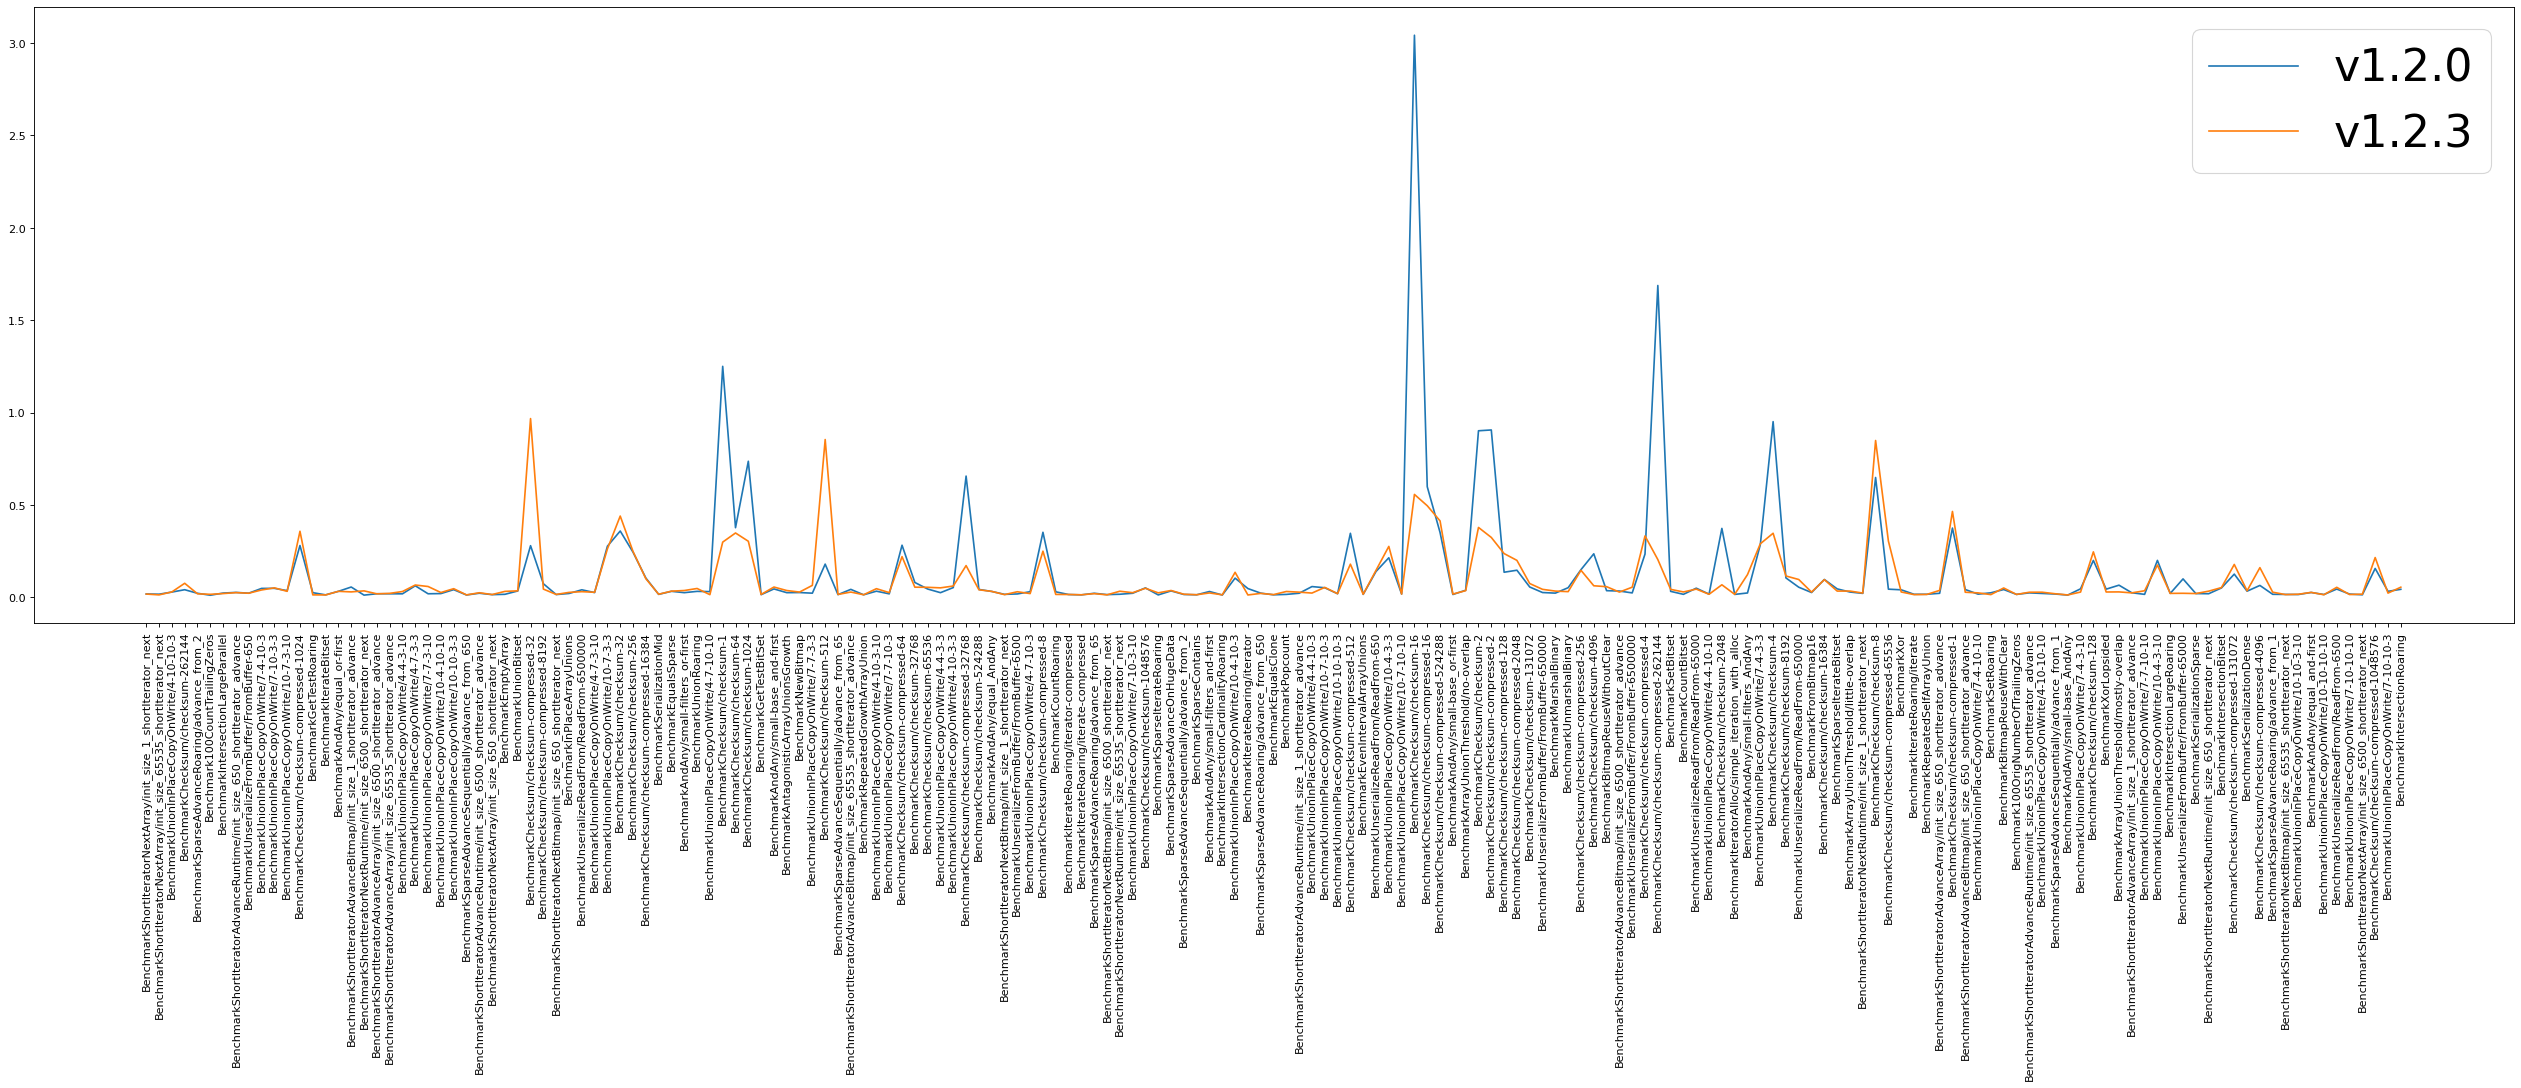

In [7]:
unstable_benchmarks = []
stability_measures = {}

plt.figure(figsize=(40, 10), dpi=80)

labels=list(next(iter(grouped_by_tag.values())).keys())
plt.xticks([x for x in range(len(labels))], labels, rotation='vertical')

for tag in grouped_by_tag.keys():
    cv = []
    spread = []
    for bench in grouped_by_tag[tag].keys():
        x = []
        measurments = grouped_by_tag[tag][bench]
        for entry in measurments:
            x.append(entry[2])
        current_cv = stats.cv(x)
        cv.append(current_cv)
        try:
            stability_measures[get_name_from_db_bench(bench)].append(current_cv)
        except KeyError:
            stability_measures[get_name_from_db_bench(bench)] = [current_cv]

        if (current_cv) > 0.5 and tag == "v1.2.0":
            print(f"{tag} {bench} {current_cv}")
            unstable_benchmarks.append(get_name_from_db_bench(bench))
        spread.append(stats.max_spread(x))

    plt.plot(cv, label=tag)
plt.legend(fontsize="40")
plt.show()

# Calculate Performance Changes

In [86]:
# Increase to 10000
changes = []
for bench in list(grouped_by_tag['v1.2.0'].keys()):
    b_mean_old = boostrap_ratio_mean_laaber(grouped_by_tag['v1.2.0'][bench], 1000)
    b_mean_new = boostrap_ratio_mean_laaber(grouped_by_tag['v1.2.3'][bench], 1000)

    R_B = []
    for i in range(len(b_mean_old)):
        R_B.append(b_mean_new[i] / b_mean_old[i])


    cl = 0.99
    lower_percentile = (1 - cl) / 2
    upper_percentile = 1 - lower_percentile
    lower_bound = np.percentile(R_B, lower_percentile * 100)
    upper_bound = np.percentile(R_B, upper_percentile * 100)
    performance_change = change(lower_bound, upper_bound)
    changes.append(performance_change)

In [91]:
perf_dict = {}
for idx, x in enumerate(changes):
    if x <= 0:
        continue
    name = list(grouped_by_tag['v1.2.0'].keys())[idx]
    name = get_name_from_db_bench(name)
    perf_dict[name] = x

# Load Graph Data

In [8]:
graph_paths0 = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/instance0/backup-mt-1-instance-0/"
graph_paths1 = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/instance1/backup-mt-1-instance-1/"

In [9]:
dot_files = []
for graph_paths in [graph_paths0, graph_paths1]:
    # Convert files to dot files for further analysis

    # Clear existing dot files
    for existingDotFile in glob.glob(graph_paths + "*.dot"):
        os.remove(existingDotFile)

    if len(glob.glob(graph_paths + "*.dot")) == 0:
        files = glob.glob(graph_paths + "*")
        for file in files:
            
            if file.endswith(".dot"):
                continue
            
            name = file.split(".out")[0]
            command = f"go tool pprof -nodecount=3000 --nodefraction=0.0 --edgefraction=0.0 -dot {name}.out > {name}.dot"
            stream = os.popen(command)
            output = stream.read()
            

    dot_files.extend(glob.glob(graph_paths + "*.dot"))

In [129]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    for node in curr_graph.nodes(data=True):
        if 'ActualBenchmark' in node[1]['label']:
            print(f"Found {node[1]['label']}")
        break

    # Removing starting nodes like file, type etc.
    try:
        name_first_node = list(curr_graph.nodes(data=True))[0][0]
        if name_first_node != "N1":
            removed_node_name.add(name_first_node)
            curr_graph.remove_node(name_first_node)
    except Exception as e:
        print(e)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

Bad input: 0
None perf benchmarks: ['05-28-2023_BenchmarkSizeRoaring', '05-28-2023_BenchmarkMemoryUsage', '05-28-2023_BenchmarkSizeBitset', '05-28-2023_BenchmarkSizeRoaring', '05-28-2023_BenchmarkMemoryUsage', '05-28-2023_BenchmarkSizeBitset']
Removed node names: {'File: roaring64.test', 'File: roaring.test', 'Type: cpu'}


In [11]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

In [12]:
final_graphs = []
for keys in ordered_graphs.keys():
    
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))

06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-7-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-10-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-7-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-7-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-4-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-10-3 

In [13]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

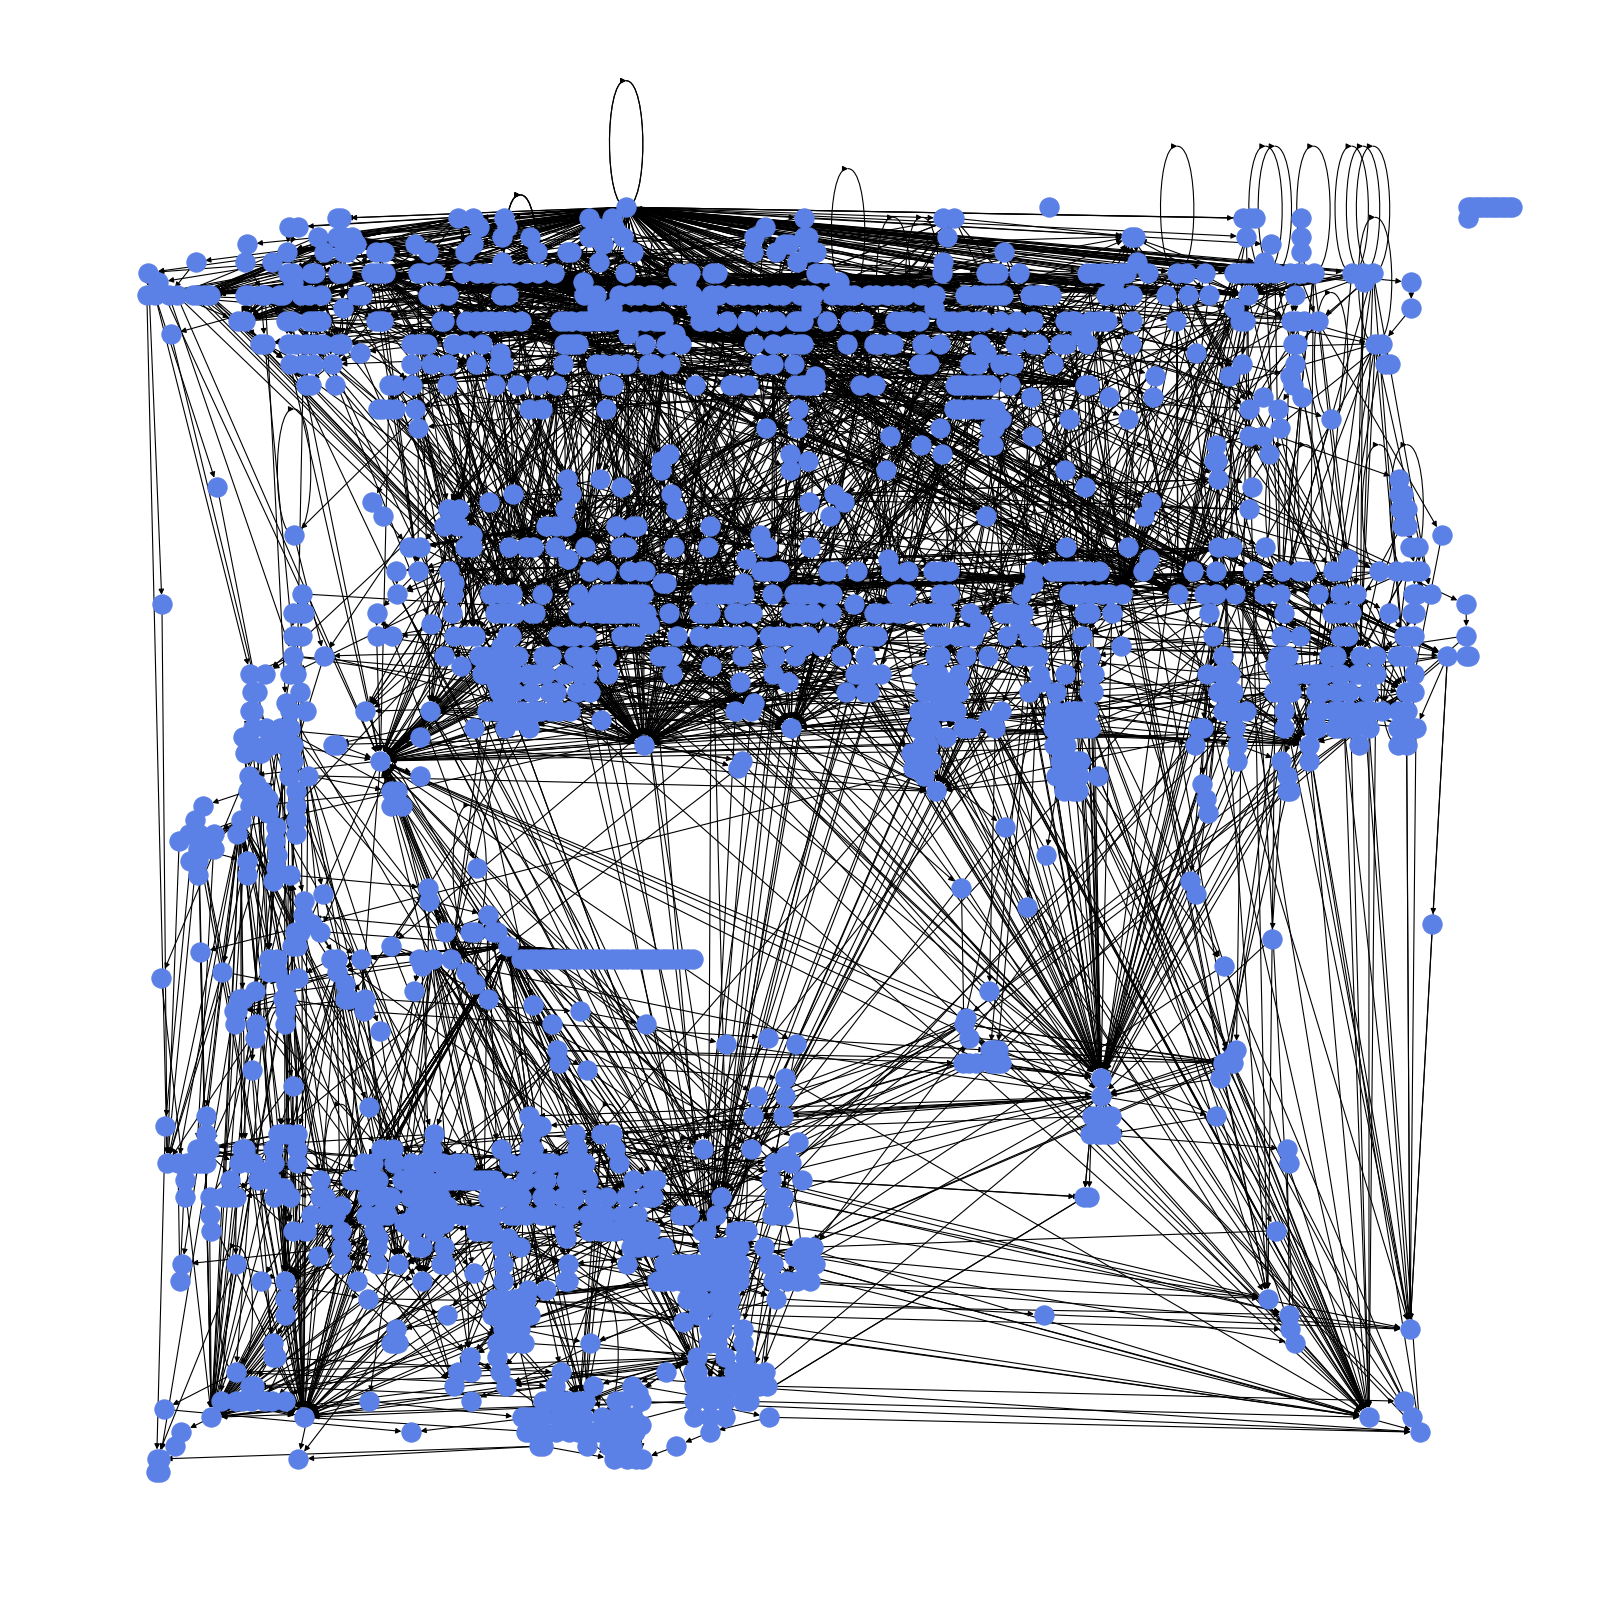

In [15]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

#### Preprocessing

In [31]:
# Remove unstable nodes where dotfile name is same as db measurement
unstable_benchmarks_idx = []
for idx, graph in enumerate(final_graphs):
    if list(ordered_graphs.keys())[idx].rsplit("_", 1)[1] in unstable_benchmarks:
        print("Removing unstable benchmark", list(ordered_graphs.keys())[idx])
        unstable_benchmarks_idx.append(idx)

print(unstable_benchmarks_idx)

Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-32768
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-262144
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-1024
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-1
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-16
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-8
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-16
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-2
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-2
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-4
[1, 38, 46, 126, 136, 140, 155, 159, 171, 205]


# Reduction Algorithm

Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more st

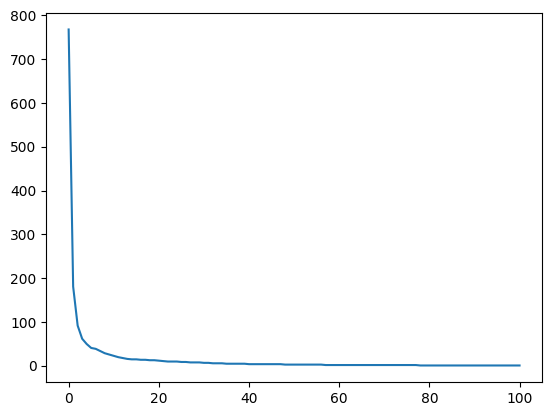

In [77]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_nodes = []
remaining_graph = full_graph.copy()
coverage_information = {}
iterations = 0
used_graph_idx = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx) or (idx in unstable_benchmarks_idx) or (idx in failed_benchs_idx):
            continue

        overlap_nodes = np.intersect1d(list(benchmark_graph.nodes()), list(remaining_graph.nodes()))
        overlap = len(overlap_nodes)

        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.nodes())}")
        break
    
    reduce_graphs_nodes.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx.append(highest_coverage[0])
    remaining_graph.remove_nodes_from(used_graph.nodes())
    iterations += 1

plt.plot([x[1] for x in reduce_graphs_nodes])
plt.show()

# Result Visualization

In [105]:
reduced_suite = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_nodes]

In [80]:
notFound = 0
failed_benchs_idx = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]
stabilities_new = []
stabilities_old = []
for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        stability = np.mean(stability_measures[name])
        stabilities_old.append(stability)
        if idx in reduced_idx:
            stabilities_new.append(stability)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 05-28-2023_BenchmarkNexts-next__1.562500% -> BenchmarkNexts-next__1.562500%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__50.000000% -> BenchmarkNexts-nextmany__50.000000%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__25.000000% -> BenchmarkNexts-nextmany__25.000000%
KeyError: 05-28-2023_BenchmarkNexts-next__0.097656% -> BenchmarkNexts-next__0.097656%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__3.125000% -> BenchmarkNexts-nextmany__3.125000%
KeyError: 05-28-2023_BenchmarkNexts-next__12.500000% -> BenchmarkNexts-next__12.500000%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__0.012352% -> BenchmarkNexts-nextmany__0.012352%
KeyError: 05-28-2023_BenchmarkNexts-next__0.390625% -> BenchmarkNexts-next__0.390625%
KeyError: 05-28-2023_BenchmarkIteratorAlloc-many_iteration -> BenchmarkIteratorAlloc-many_iteration
KeyError: 05-28-2023_BenchmarkIteratorAlloc-simple_iteration -> BenchmarkIteratorAlloc-simple_iteration
KeyError: 05-28-2023_BenchmarkNextsRLE-next -> BenchmarkNextsRLE-next


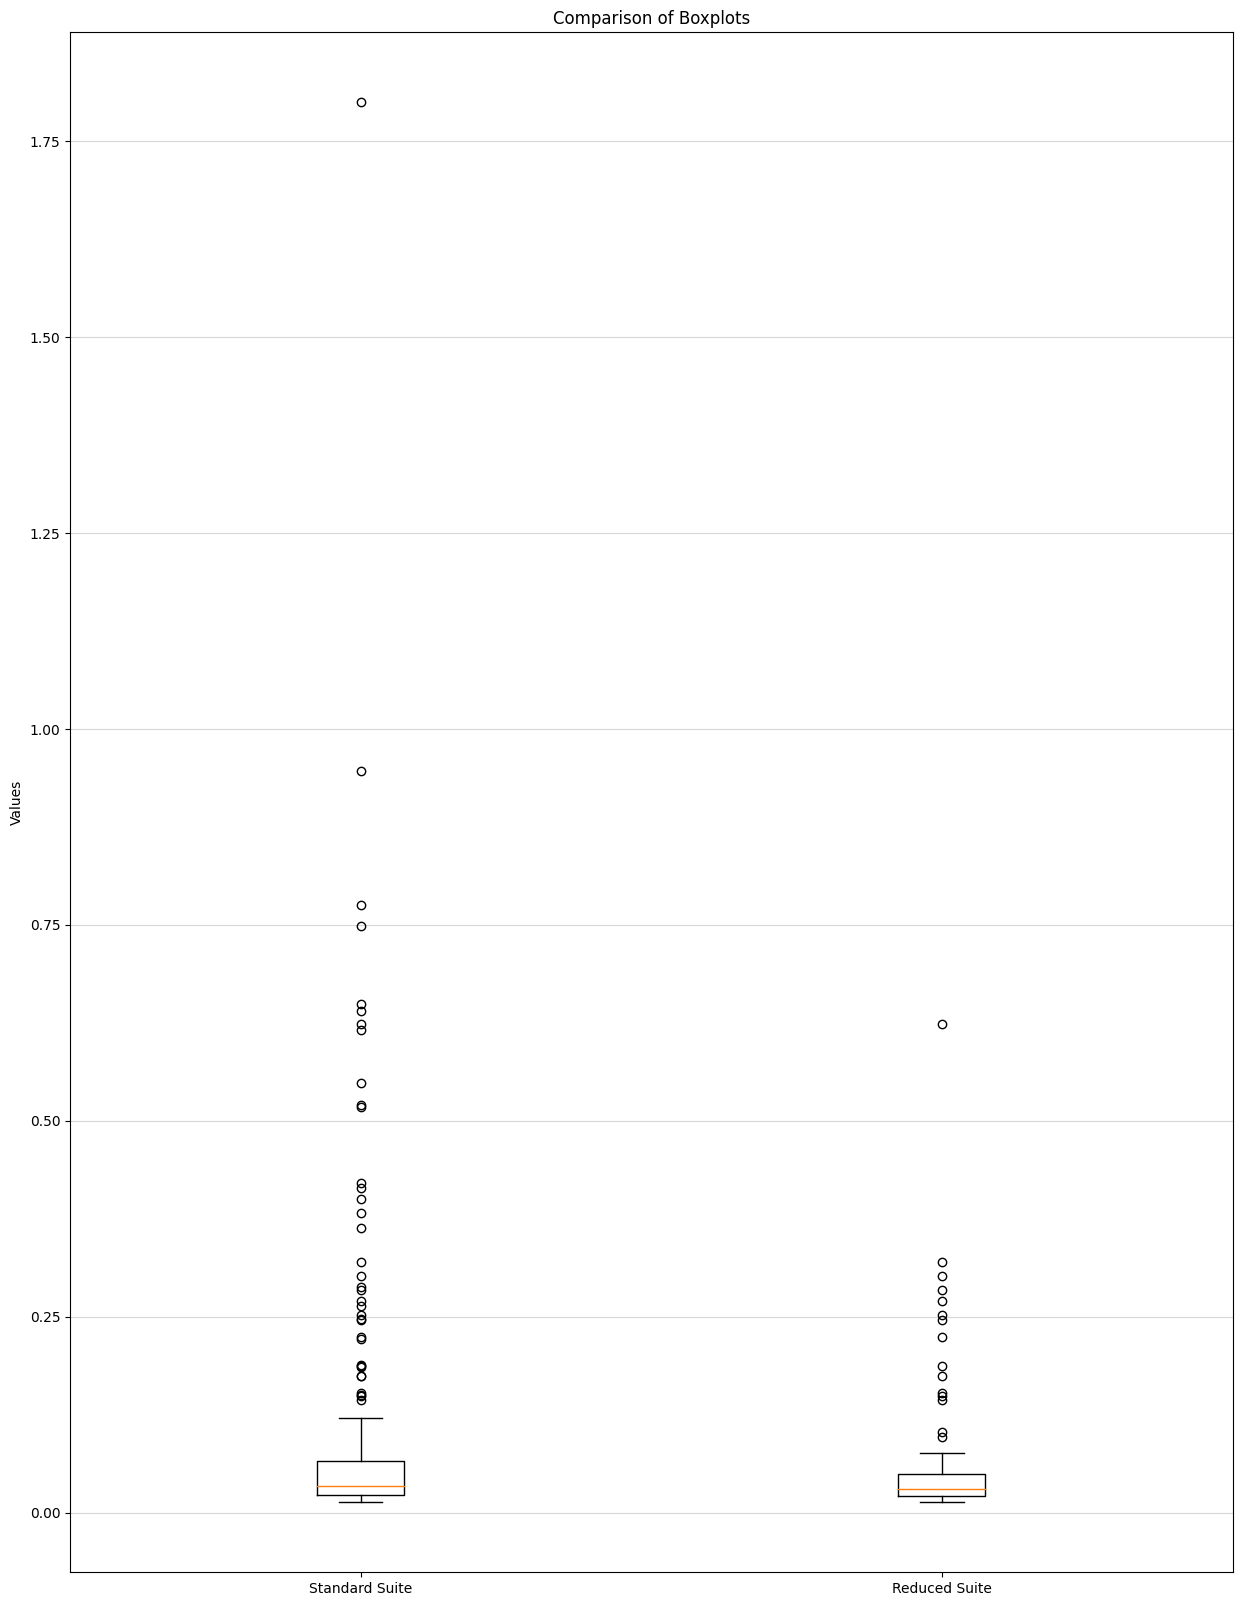

In [140]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(15, 20))
boxplot = ax.boxplot(data, positions=[1, 2], labels=['Standard Suite', 'Reduced Suite'])
ax.set_ylabel('Values')
ax.set_title('Comparison of Boxplots')
ax.grid(axis='y', alpha=0.50)

plt.show()

In [141]:
found_changes = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes.append(perf_dict[name])
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 05-28-2023_BenchmarkShortIteratorAdvanceRuntime-init_size_6500_shortIterator_advance -> BenchmarkShortIteratorAdvanceRuntime-init_size_6500_shortIterator_advance
KeyError: 05-28-2023_BenchmarkSetBitset -> BenchmarkSetBitset
KeyError: 05-28-2023_BenchmarkChecksum-checksum-compressed-256 -> BenchmarkChecksum-checksum-compressed-256
KeyError: 05-28-2023_BenchmarkSerializationSparse -> BenchmarkSerializationSparse
KeyError: 05-28-2023_BenchmarkChecksum-checksum-16384 -> BenchmarkChecksum-checksum-16384
KeyError: 05-28-2023_BenchmarkBitmapReuseWithClear -> BenchmarkBitmapReuseWithClear
KeyError: 05-28-2023_BenchmarkGetTestBitSet -> BenchmarkGetTestBitSet
KeyError: 06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-10-3-3 -> BenchmarkUnionInPlaceCopyOnWrite-4-10-3-3
KeyError: 05-28-2023_BenchmarkSerializationDense -> BenchmarkSerializationDense
KeyError: 05-28-2023_BenchmarkPopcount -> BenchmarkPopcount
KeyError: 05-28-2023_BenchmarkMarshalBinary -> BenchmarkMarshalBinary
KeyError: 05-2

In [144]:
print(len(found_changes))
print(len(perf_dict.keys()))

17
27


In [150]:
found_changes

[1.1811426278528825,
 0.48216995743326496,
 32.46555473846843,
 0.5756113293268639,
 0.34848452847302536,
 1.090100782356651,
 1.235021906657452,
 0.503225200176538,
 0.4146422443817799,
 0.4479202832739393,
 7.747636649752199,
 46.10869300615159,
 4.411068948791497,
 10.346523661921747,
 1.0593383710804316,
 2.0608831314249287,
 5.4972005498920335]

In [151]:
for change in perf_dict.values():
    if change in found_changes:
        continue
    print(change)

7.163661926518361
0.09957599131182882
0.23121571283141185
1.4357522597579386
5.130697452240884
4.219031671235496
1.2946541685372237
0.15591168091165786
1.3578091046676288
7.686803354446992


In [147]:
not_found = []
for change_b in perf_dict.keys():
    if change_b in reduced_suite:
        print(change_b)
    else:
        not_found.append(change_b)

In [148]:
not_found

['BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next',
 'BenchmarkSparseAdvanceRoaring-advance_from_2',
 'BenchmarkShortIteratorAdvanceArray-init_size_65535_shortIterator_advance',
 'BenchmarkUnionInPlaceCopyOnWrite-10-4-10-10',
 'BenchmarkShortIteratorNextArray-init_size_650_shortIterator_next',
 'BenchmarkShortIteratorNextBitmap-init_size_650_shortIterator_next',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10',
 'BenchmarkShortIteratorNextBitmap-init_size_1_shortIterator_next',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3',
 'BenchmarkIterateRoaring-iterator-compressed',
 'BenchmarkIterateRoaring-iterate-compressed',
 'BenchmarkSparseAdvanceRoaring-advance_from_65',
 'BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next',
 'BenchmarkSparseIterateRoaring',
 'BenchmarkAndAny-small-filters_and-first',
 'BenchmarkSparseAdvanceRoaring-advance_from_650',
 'BenchmarkEqualsClone',
 'BenchmarkChecksum-checksum-compressed-262144',
 'BenchmarkCountBitset',
 'Benchma

In [116]:
# Check if graphs overlap with reduced suite
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_nodes = np.intersect1d(list(graph.nodes()), list(selected_graph.nodes()))

                # calculate percentage of overlap with graph
                overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                if overlap_percentage > 0.9:
                    if change != 'BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next':
                        print(f"Missing benchmark {change} overlaps with {name}: {overlap_percentage}")
                    newly_found.add(change)

Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-10-4-10-10 overlaps with BenchmarkUnmarshalBinary: 0.9130434782608695
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnserializeReadFrom-ReadFrom-6500: 0.9245283018867925
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkAndAny-small-filters_AndAny: 0.9150943396226415
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnserializeReadFrom-ReadFrom-650: 0.9245283018867925
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnmarshalBinary: 0.9056603773584906
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkAndAny-small-filters_or-first: 0.9056603773584906
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnserializeReadFrom-ReadFrom-65000: 0.9056603773584906
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkSe

In [113]:
newly_found

{'BenchmarkChecksum-checksum-compressed-262144',
 'BenchmarkIterateRoaring-iterate-compressed',
 'BenchmarkIterateRoaring-iterator-compressed',
 'BenchmarkShortIteratorNextArray-init_size_6500_shortIterator_next',
 'BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next',
 'BenchmarkShortIteratorNextRuntime-init_size_650_shortIterator_next',
 'BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next',
 'BenchmarkUnionInPlaceCopyOnWrite-10-4-10-10',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3'}

# Time saved

In [139]:
print("Old suite runtime in minutes:", len(final_graphs) * 5 * 3 * 1 / 60)
print("Reduced Suite runtime in minute:", len(reduced_idx) * 5 * 3 * 1 / 60)

Old suite runtime in minutes: 51.75
Reduced Suite runtime in minute: 25.25
